In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import pandas as pd
import numpy as np
from model.link_net import LinkNet18
from pathlib import Path
import random
import os
from utils.scripts import rle_decode
import cv2
from torchvision.transforms import functional as T

C:\Users\vanou\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:37: UserWarning: Unsupported `ReduceOp` for distributed computing.
  warnings.warn(*args, **kwargs)


In [2]:
DATA_DIR = Path('input')
TRAIN_DIR = DATA_DIR / 'train'
TEST_DIR = DATA_DIR / 'test'
TRAIN_MASKS = DATA_DIR / 'train_masks'
MODEL = Path(r'model/linknet18_epoch9_val_loss0.983.pth')

In [3]:
train_df = pd.read_csv(DATA_DIR / 'train_masks.csv')

In [4]:
samples = train_df.sample(5).reset_index()
samples

,index,img,rle_mask
0,2567,784ca55262c2_08.jpg,630159 2 632077 2 633995 1 635912 2 637830 2 6...
1,992,31186febd775_01.jpg,831397 65 833286 117 835185 153 837087 183 838...
2,4086,cf65b1c5e147_07.jpg,770096 87 771989 158 772227 15 773889 197 7741...
3,1508,42a3297ccd4b_05.jpg,711079 1 712996 2 714914 2 716831 2 718748 3 7...
4,4446,df642435a951_15.jpg,971366 71 973256 130 975154 172 977052 209 978...


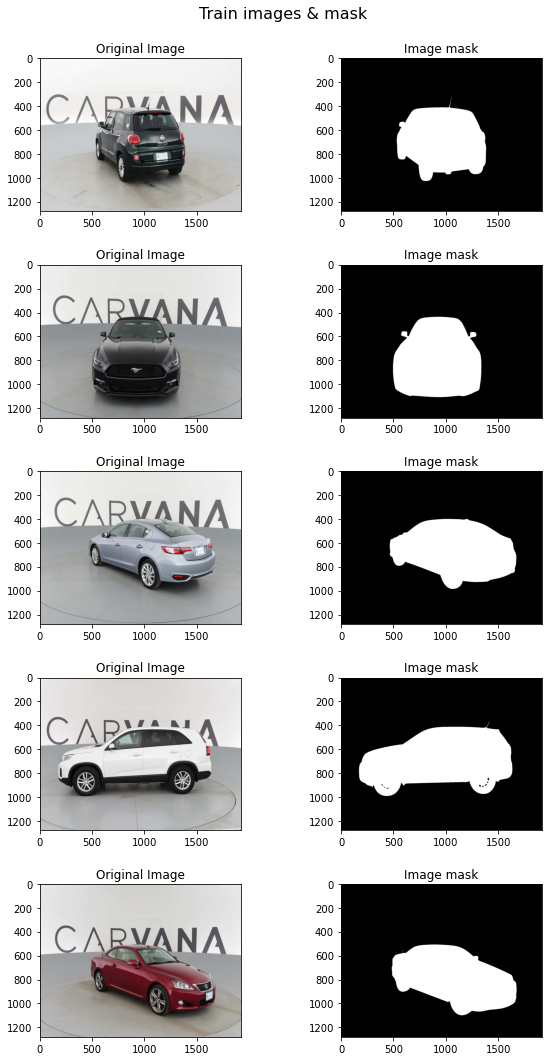

In [5]:
fig, axs = plt.subplots(5, 2, figsize=(9, 18))
fig.subplots_adjust(hspace = .35, wspace=.5)
fig.suptitle('Train images & mask', fontsize=16, y=0.92)

for i, row in samples.iterrows():
    img = cv2.imread(str(TRAIN_DIR / row['img']))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    axs[i, 0].imshow(img, aspect='auto')
    axs[i, 0].set_title('Original Image')
    mask = rle_decode(row['rle_mask'], (img.shape[0], img.shape[1]))
    axs[i, 1].imshow(mask, cmap='gray', aspect='auto')
    axs[i, 1].set_title('Image mask')

fig.savefig('assets/asset1.jpg', bbox_inches='tight')

In [6]:
test_df = pd.read_csv(DATA_DIR / 'sample_submission.csv')
samples = test_df.sample(5).reset_index(drop=True)
samples

,img,rle_mask
0,68493cadb046_09.jpg,1 1
1,60b450725fdf_02.jpg,1 1
2,7bc3c25d80f7_01.jpg,1 1
3,d062f57c4d09_08.jpg,1 1
4,48d9dd3826a3_11.jpg,1 1


In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = LinkNet18(num_classes=1)
model.load_state_dict(torch.load(MODEL))
model.to(device)
model.eval()

LinkNet18(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (encoder1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=Tr

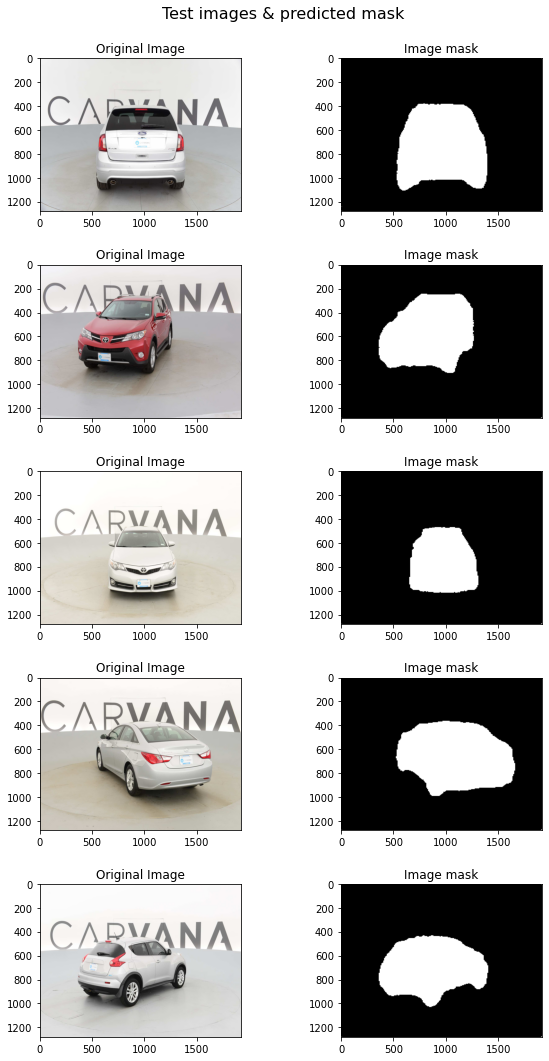

In [8]:
fig, axs = plt.subplots(5, 2, figsize=(9, 18))
fig.subplots_adjust(hspace = .35, wspace=.5)
fig.suptitle('Test images & predicted mask', fontsize=16, y=0.92)

for i, row in samples.iterrows():
    img_orig = cv2.imread(str(TEST_DIR / row['img']))
    img_orig = cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img_orig, (224, 224), interpolation=cv2.INTER_AREA)
    img = T.to_tensor(img).unsqueeze(0)
    
    out = model(img.to(device))
    out = torch.sigmoid(out) * 255
    out = nn.functional.interpolate(out, (1280, 1918))
    out = out.squeeze(0).squeeze(0)
    out = out.data.cpu().numpy()
    mask = (out > 0.005).astype(np.uint8)
    
    axs[i, 0].imshow(img_orig, aspect='auto')
    axs[i, 0].set_title('Original Image')
    axs[i, 1].imshow(mask, cmap='gray', aspect='auto')
    axs[i, 1].set_title('Image mask')

fig.savefig('assets/asset2.jpg', bbox_inches='tight')